In [1]:
%cd '/content/drive/MyDrive/Photomath/assignment-A'

/content/drive/MyDrive/Photomath/assignment-A


# Load packages

In [2]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -U -q imgaug

     |████████████████████████████████| 3.4 MB 4.5 MB/s 
     |████████████████████████████████| 596 kB 55.2 MB/s 
     |████████████████████████████████| 895 kB 60.6 MB/s 
     |████████████████████████████████| 3.3 MB 52.2 MB/s 
     |████████████████████████████████| 61 kB 134 kB/s 
     |████████████████████████████████| 1.2 MB 5.4 MB/s 
     |████████████████████████████████| 948 kB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [3]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import random
import gdown

In [4]:
seq = iaa.Sequential([
    iaa.Sometimes(
        0.5,
        [
            iaa.Sometimes(
                0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            iaa.Sometimes(
                0.5,
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
            ),
            iaa.Sometimes(
                0.5,
                iaa.CLAHE()
            ),
            iaa.Sometimes(
                0.5,
                iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0))
            ),
            iaa.Sometimes(
                0.5,
                iaa.Affine(
                    scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                    translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
                    rotate=(-1, 1),
                    shear=(-2, 2),
                    cval=(255)
                )
            )
        ]
    )
], random_order=True)

In [5]:
class ExpressionGenerator:
    """
    ExpressionGenerator Generates mathematical expressions
    """

    # sign_list = ["+", "-", "x", "/"]
    sign_list = ["+", "-", "x", "/", "(", ")", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

    def __init__(self, number_of_expressions):
        self.number_of_expressions = number_of_expressions

    @staticmethod
    def generateExpression():
        # """
        # Generates mathematical expressions
        # Returns:
        #     result (str): Mathematical expression
        # """

        number_of_chars = np.random.randint(2, 20)
        ex = ""
        for i in range(number_of_chars):
            ex += np.random.choice(ExpressionGenerator.sign_list)
        return ex

# Download dataset of non-numeric characters: +-x/().

In [6]:
url = 'https://drive.google.com/uc?id=1hjdN2Jo8Dli8YC7NskSMsodakTWU9lR0'
output = '/datasset.zip'

gdown.download(url, output, quiet=False)

!unzip -qq /datasset.zip -d /
!rm /datasset.zip

Downloading...
From: https://drive.google.com/uc?id=1hjdN2Jo8Dli8YC7NskSMsodakTWU9lR0
To: /datasset.zip
100%|██████████| 85.6M/85.6M [00:00<00:00, 108MB/s]


In [7]:
IMG_DIMS = 28
id2label = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: '+',
    11: '-',
    12: 'times',
    13: 'forward_slash',
    14: '(',
    15: ')',
}

label2id = {value: key for key, value in id2label.items()}
NUMBER_OF_LABELS = len(id2label)

dataset_path = Path('/dataset')
non_digit_images, non_digit_labels = [], []
kernel = np.ones((3, 3), np.uint8)
for img_path in dataset_path.glob('**/*.jpg'):
    img = 255-cv2.imread(img_path.as_posix(), cv2.IMREAD_GRAYSCALE)
    img = cv2.dilate(img, kernel)
    img = cv2.resize(img, (IMG_DIMS, IMG_DIMS), interpolation = cv2.INTER_AREA)

    non_digit_images.append(img)
    non_digit_labels.append(label2id[img_path.parent.stem])

non_digit_images = np.stack(non_digit_images, axis=0)
non_digit_labels = np.stack(non_digit_labels, axis=0)

# Load MNIST dataset from Tensorflow hub
The dataset consists of the digits from 0 to 9

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [9]:
X = np.concatenate([x_train, x_test, non_digit_images], axis=0)
y = np.concatenate([y_train, y_test, non_digit_labels], axis=0)

label_positions = {}
for i in range(NUMBER_OF_LABELS):
    label_positions[id2label[i]] = np.where(y == i)[0]

In [10]:
def generate_expression_image():
    expression = ExpressionGenerator.generateExpression()
    image = np.zeros((IMG_DIMS, IMG_DIMS*len(expression)*2), dtype=np.int32)
    curr_pos = 20
    for char in expression:
        max_shift = 25 if char.isdigit() else 40
        shift = np.random.randint(12, 40, size=1)[0]
        char = char.replace('x', 'times').replace('/', 'forward_slash')
        position = np.random.choice(label_positions[char])
        image[:, curr_pos:curr_pos+IMG_DIMS] += X[position]
        curr_pos += shift
    curr_pos += shift
    image[image>255] = 255
    image = 255-image[:, :curr_pos].astype(np.uint8)

    if bool(random.getrandbits(1)):
        top, bottom, left, right = np.random.randint(5, 50, size=4)
        image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    image = seq(image=image)
    image = Image.fromarray(image.astype(np.uint8)).convert("RGB")
    return expression, image

In [11]:
import torch
from torch.utils.data import Dataset

class ExpressionDataset(Dataset):
    def __init__(self, tokenizer, feature_extractor, is_training=False, max_target_length=128):
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_target_length = max_target_length
        self.is_training = is_training

    def __len__(self):
        if self.is_training:
            return 50000
        return 200

    def __getitem__(self, idx):
        text, image = generate_expression_image()
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [12]:
from transformers import AutoFeatureExtractor, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/trocr-small-handwritten")
feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/trocr-small-handwritten')

train_dataset = ExpressionDataset(tokenizer=tokenizer,
                           feature_extractor=feature_extractor,
                           is_training=True)
eval_dataset = ExpressionDataset(tokenizer=tokenizer,
                          feature_extractor=feature_extractor,
                          is_training=False)

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/238 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

-+76/0+


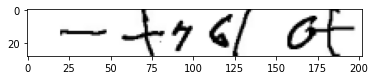

6/-x63034


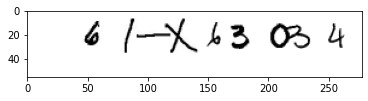

0(208)/


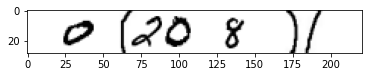

6x4(+46x66


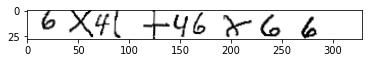

69x+86723(/9(4


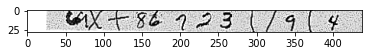

In [13]:
for i in range(5):
    exp, img = generate_expression_image()
    print(exp)
    plt.imshow(img)
    plt.show()

In [14]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


In [15]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")

Downloading:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.config.bos_token_id = tokenizer.bos_token_id

In [17]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [18]:
!pip install -q datasets jiwer

     |████████████████████████████████| 306 kB 5.3 MB/s 
     |████████████████████████████████| 132 kB 67.7 MB/s 
     |████████████████████████████████| 243 kB 67.9 MB/s 
     |████████████████████████████████| 1.1 MB 68.2 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 160 kB 72.0 MB/s 
     |████████████████████████████████| 271 kB 73.0 MB/s 
     |████████████████████████████████| 192 kB 71.0 MB/s 


In [19]:
from datasets import load_metric

cer_metric = load_metric("cer")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [20]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [21]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using amp half precision backend
***** Running training *****
  Num examples = 50000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 9375


Step,Training Loss,Validation Loss,Cer
200,0.738500,0.730220,0.178679
400,0.655600,0.650803,0.151471
600,0.633200,0.554770,0.184521
800,0.489700,0.538036,0.120304
1000,0.574800,0.653052,0.149709
1200,0.521000,0.483202,0.120419
1400,0.545700,0.498375,0.137112
1600,0.553000,0.530792,0.113825
1800,0.430400,0.404056,0.137397
2000,0.480900,0.448811,0.144290


***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
Configuration saved in ./checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpo

TrainOutput(global_step=9375, training_loss=0.3175970454454422, metrics={'train_runtime': 6519.1484, 'train_samples_per_second': 23.009, 'train_steps_per_second': 1.438, 'total_flos': 1.79437031129088e+19, 'train_loss': 0.3175970454454422, 'epoch': 3.0})

In [22]:
model.save_pretrained('./transformer_model')

Configuration saved in ./transformer_model/config.json
Model weights saved in ./transformer_model/pytorch_model.bin
